<a href="https://colab.research.google.com/github/trungphan9x/ML_project1/blob/master/trung_colab_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS582 Machine Learning - Mini Project 1

Professor: Anthony Sander

Team:


*   Khoa Nam Nguyen
*   Thai Trung Phan

Dataset: https://www.kaggle.com/camnugent/california-housing-prices



# Loading all libraries

In [1]:
!pip uninstall scikit-learn -y
!pip install scikit-learn==0.24.0
!pip install auto-sklearn
!pip install lime
!pip install shap

Found existing installation: scikit-learn 0.24.0
Uninstalling scikit-learn-0.24.0:
  Successfully uninstalled scikit-learn-0.24.0
  Using cached scikit_learn-0.24.0-cp37-cp37m-manylinux2010_x86_64.whl (22.3 MB)


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer



from autosklearn.experimental.askl2 import AutoSklearn2Classifier
import autosklearn.classification
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics

# STEP 1: LOADING DATASET

Min of 500 samples , must include at least one categorical feature

In [3]:
!git clone https://github.com/trungphan9x/ML_project1.git

fatal: destination path 'ML_project1' already exists and is not an empty directory.


In [4]:
housing = pd.read_csv('/content/ML_project1/dataset/Cali_housing_prices/housing.csv')

# STEP 2: EDA

# Identify if there are any missing values


> There are 20,640 instances in the dataset. Notice that the total_bed rooms attribute has only 20,433 nonnull values, meaning that 207 districts are missing this feature. We will need to take care of this.






In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


# Identify categorical feature



> All attributes are numerical, except the ocean_proximity field. When you looked at the top five rows, you probably noticed that the values in the ocean_proximity column were repetitive, which means that it is probably a categorical attribute 

In [6]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY




> Check what categories exist and how many districts belong to each category



In [7]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

# Summary of the numerical atributes

In [8]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


# Ploting a histogram of each numerical atribute

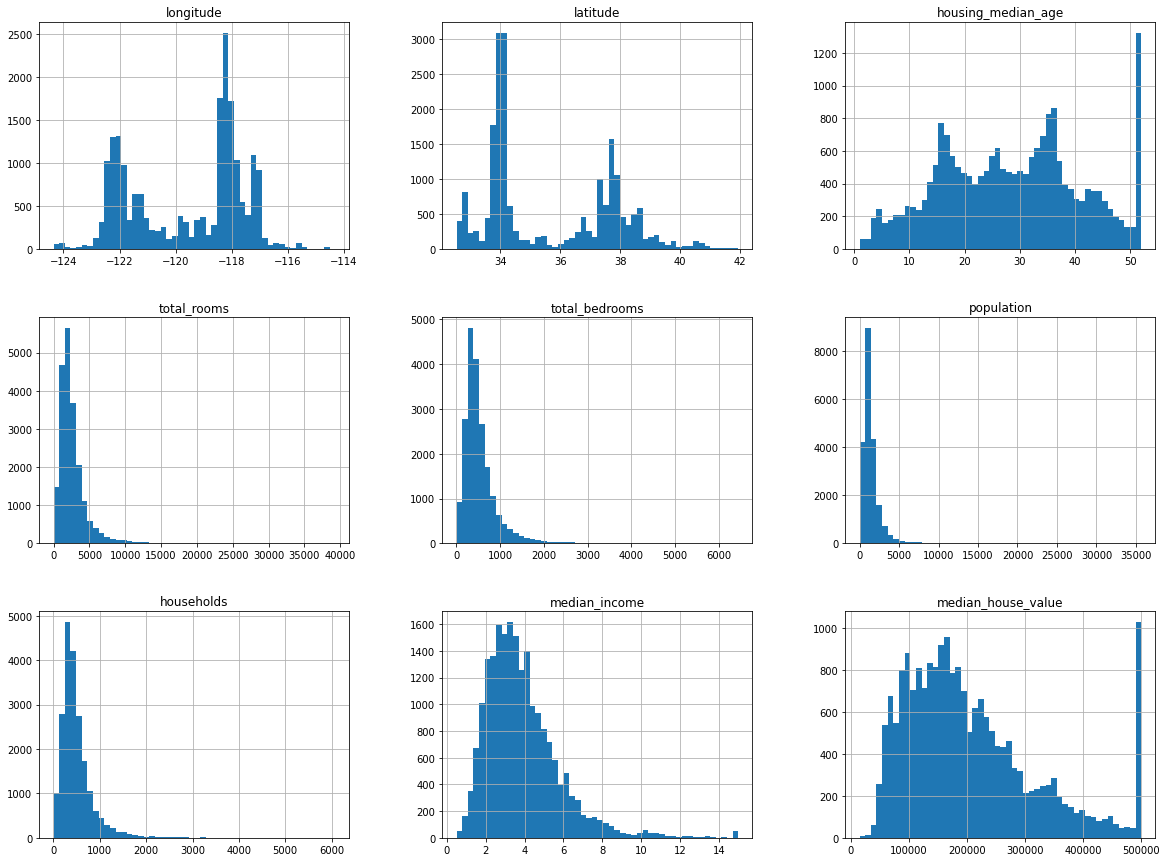

In [9]:
housing.hist(bins=50, figsize=(20,15)) 
plt.show()



> There are a few things you might notice in these histograms:


1.   The median house value is our target attribute (our labels).
2.   The median income attribute: the numbers represent roughly tens of thousands of dollars (e.g., 3 actually means about $30,000).
3.   These attributes have very different scales.
4.   Finally, many histograms are tail-heavy: they extend much farther to the right of the median than to the left. This may make it a bit harder for some Machine Learning algorithms to detect patterns. We will try transforming these attributes later on to have more bell-shaped distributions.






# Visualizing Geographical Data

Create a scatterplot of all districts to visualize the data

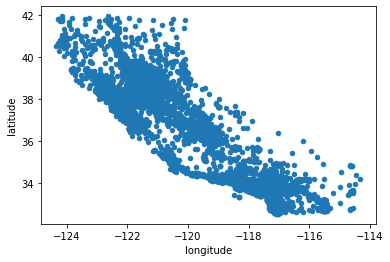

In [10]:
housing.plot(kind="scatter", x="longitude", y="latitude")

This looks like California actually. Setting the alpha option to 0.1 makes it much easier to visualize the places where there is a high density of data points:

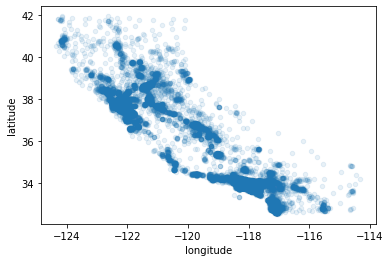

In [11]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

Now that’s much better: you can clearly see the high-density areas, namely the Bay Area and around Los Angeles and San Diego, plus a long line of fairly high density in the Central Valley, in particular around Sacramento and Fresno.


Now let’s look at the housing prices (Figure 2-13). The radius of each circle represents the district’s population (option s), and the color represents the price (option c). We will use a predefined color map (option cmap) called jet, which ranges from blue (low values) to red (high prices):

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


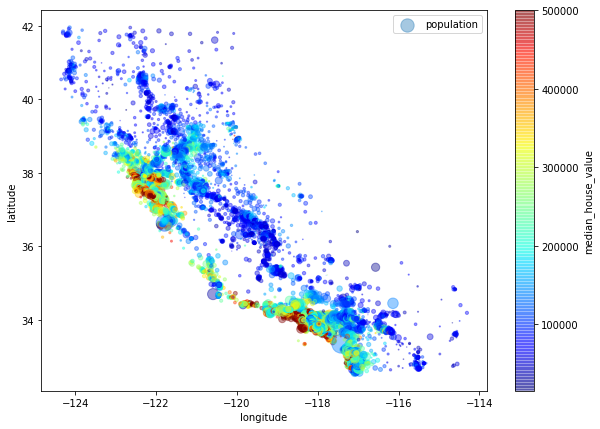

In [12]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="population", figsize=(10,7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)
plt.legend()

This image tells you that the housing prices are very much related to the location (e.g., close to the ocean) and to the population density. A clustering algorithm should be useful for detecting the main cluster and for adding new features that measure the proximity to the cluster centers. The ocean proximity attribute may be useful as well, although in Northern California the housing prices in coastal districts are not too high, so it is not a simple rule.

# Correlations

In [13]:
corr_matrix = housing.corr()

Now let’s look at how much each attribute correlates with the median house value:

In [14]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

When it is close to 1, it means that there is a strong positive correlation; for example, the median house value tends to go up when the median income goes up

When the coefficient is close to –1, it means that there is a strong negative correlation; you can see a small negative correlation between the latitude and the median house value (i.e., prices have a slight tendency to go down when you go north).

Another way to check for correlation between attributes is to use the pandas scatter_matrix() function

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb3ccd35110>,
      dtype=object)

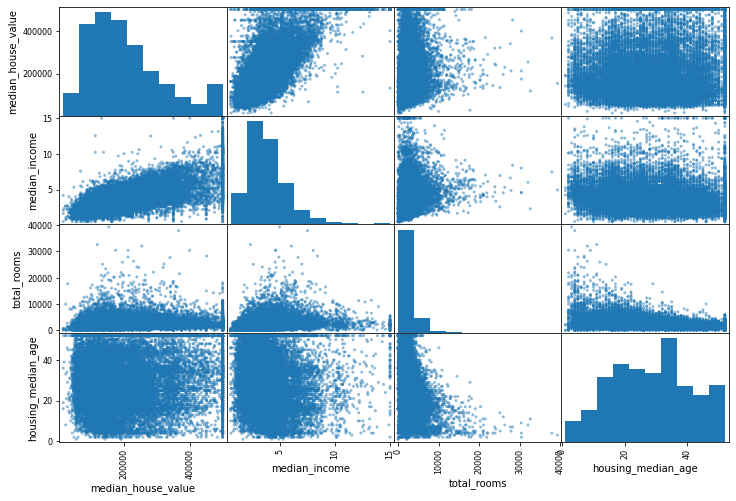

In [15]:
attributes = ["median_house_value", "median_income", "total_rooms","housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

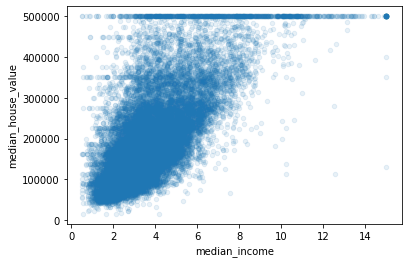

In [16]:
 housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

# Atribute Combination

In [17]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [18]:
corr_matrix = housing.corr()

In [19]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64

The new bedrooms_per_room attribute is much more correlated with the median house value than the total number of rooms or bedrooms.

Apparently houses with a lower bedroom/room ratio tend to be more expensive. 

The larger the houses, the more expensive they are.

# STEP 3: DATA PREPARATION

# Handle the categorical columns

In [20]:
le = LabelEncoder()
housing['ocean_proximity'] = le.fit_transform(housing['ocean_proximity'])


In [21]:
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,3,6.984127,0.146591,2.555556
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,3,6.238137,0.155797,2.109842
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,3,8.288136,0.129516,2.802260
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,3,5.817352,0.184458,2.547945
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,3,6.281853,0.172096,2.181467
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,1,5.045455,0.224625,2.560606
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,1,6.114035,0.215208,3.122807
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,1,5.205543,0.215173,2.325635
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,1,5.329513,0.219892,2.123209


#  Processing missing values

Create a SimpleImputer instance, specifying that you want to replace each attribute’s missing values with the median of that attribute:

In [22]:
imputer = SimpleImputer(strategy="median")

Fit the imputer instance to the training data using the fit() method:

In [23]:
imputer.fit(housing)

SimpleImputer(strategy='median')

In [24]:
imputer.statistics_

array([-1.18490000e+02,  3.42600000e+01,  2.90000000e+01,  2.12700000e+03,
        4.35000000e+02,  1.16600000e+03,  4.09000000e+02,  3.53480000e+00,
        1.79700000e+05,  1.00000000e+00,  5.22912879e+00,  2.03162434e-01,
        2.81811565e+00])

Use this “trained” imputer to transform the training set by replacing missing values with the learned medians:

In [25]:
X = imputer.transform(housing)

The result is a plain NumPy array containing the transformed features. If you want to put it back into a pandas DataFrame, it’s simple:

In [26]:
housing = pd.DataFrame(X, columns=housing.columns, index=housing.index)
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,3.0,6.984127,0.146591,2.555556
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,3.0,6.238137,0.155797,2.109842
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,3.0,8.288136,0.129516,2.802260
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,3.0,5.817352,0.184458,2.547945
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,3.0,6.281853,0.172096,2.181467
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,1.0,5.045455,0.224625,2.560606
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,1.0,6.114035,0.215208,3.122807
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,1.0,5.205543,0.215173,2.325635
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,1.0,5.329513,0.219892,2.123209


In [27]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   longitude                 20640 non-null  float64
 1   latitude                  20640 non-null  float64
 2   housing_median_age        20640 non-null  float64
 3   total_rooms               20640 non-null  float64
 4   total_bedrooms            20640 non-null  float64
 5   population                20640 non-null  float64
 6   households                20640 non-null  float64
 7   median_income             20640 non-null  float64
 8   median_house_value        20640 non-null  float64
 9   ocean_proximity           20640 non-null  float64
 10  rooms_per_household       20640 non-null  float64
 11  bedrooms_per_room         20640 non-null  float64
 12  population_per_household  20640 non-null  float64
dtypes: float64(13)
memory usage: 2.0 MB


# Convert Regression dataset to Binary Classification dataset

In [28]:
housing['median_house_value'] = np.where(housing['median_house_value']>200000.0,1,0)
housing.rename(columns={'median_house_value': 'expensive'}, inplace= True)

In [29]:
housing['expensive'].value_counts()

0    11931
1     8709
Name: expensive, dtype: int64

In [30]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   longitude                 20640 non-null  float64
 1   latitude                  20640 non-null  float64
 2   housing_median_age        20640 non-null  float64
 3   total_rooms               20640 non-null  float64
 4   total_bedrooms            20640 non-null  float64
 5   population                20640 non-null  float64
 6   households                20640 non-null  float64
 7   median_income             20640 non-null  float64
 8   expensive                 20640 non-null  int64  
 9   ocean_proximity           20640 non-null  float64
 10  rooms_per_household       20640 non-null  float64
 11  bedrooms_per_room         20640 non-null  float64
 12  population_per_household  20640 non-null  float64
dtypes: float64(12), int64(1)
memory usage: 2.0 MB


# Create trainset and testset

The median income is a very important attribute to predict median housing prices. We may want to ensure that the test set is representative of the various categories of incomes in the whole dataset. So we are gonna create an income category attribute with five categories:

In [31]:
housing["income_cat"] = pd.cut(housing["median_income"],bins=[0., 1.5, 3.0, 4.5, 6., np.inf],labels=[1, 2, 3, 4, 5])

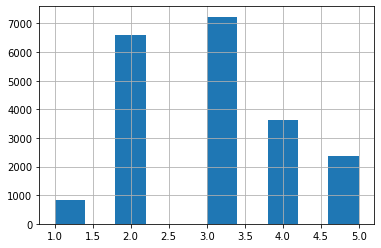

In [32]:
 housing["income_cat"].hist()

In [33]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

In [34]:
for train_index, test_index in split.split(housing, housing["income_cat"]):
        strat_train_set = housing.loc[train_index]
        strat_test_set = housing.loc[test_index]

In [35]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [36]:
strat_train_set["income_cat"].value_counts() / len(strat_train_set)

3    0.350594
2    0.318859
4    0.176296
5    0.114402
1    0.039850
Name: income_cat, dtype: float64

Then remove the income_cat attribute so the data is back to its original

In [37]:
for set_ in (strat_train_set, strat_test_set): 
  set_.drop("income_cat", axis=1, inplace=True)

Separate the predictors and the labels, since we don’t necessarily want to apply the same transformations to the predictors and the target values:

In [38]:
housing = strat_train_set.drop("expensive", axis=1)
housing_labels = strat_train_set["expensive"].copy()

In [39]:
X_test = strat_test_set.drop("expensive", axis=1)
y_test = strat_test_set["expensive"].copy()

In [40]:
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,0.0,4.625369,0.223852,2.094395
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,0.0,6.008850,0.159057,2.707965
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,4.0,4.225108,0.241291,2.025974
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,1.0,5.232295,0.200866,4.135977
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,0.0,4.505810,0.231341,3.047847
...,...,...,...,...,...,...,...,...,...,...,...,...
6563,-118.13,34.20,46.0,1271.0,236.0,573.0,210.0,4.9312,1.0,6.052381,0.185681,2.728571
12053,-117.56,33.88,40.0,1196.0,294.0,1052.0,258.0,2.0682,1.0,4.635659,0.245819,4.077519
13908,-116.40,34.09,9.0,4855.0,872.0,2098.0,765.0,3.2723,1.0,6.346405,0.179609,2.742484
11159,-118.01,33.82,31.0,1960.0,380.0,1356.0,356.0,4.0625,0.0,5.505618,0.193878,3.808989


In [41]:
X_test

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
5241,-118.39,34.12,29.0,6447.0,1012.0,2184.0,960.0,8.2816,0.0,6.715625,0.156972,2.275000
10970,-117.86,33.77,39.0,4159.0,655.0,1669.0,651.0,4.6111,0.0,6.388633,0.157490,2.563748
20351,-119.05,34.21,27.0,4357.0,926.0,2110.0,876.0,3.0119,0.0,4.973744,0.212532,2.408676
6568,-118.15,34.20,52.0,1786.0,306.0,1018.0,322.0,4.1518,1.0,5.546584,0.171333,3.161491
13285,-117.68,34.07,32.0,1775.0,314.0,1067.0,302.0,4.0375,1.0,5.877483,0.176901,3.533113
...,...,...,...,...,...,...,...,...,...,...,...,...
20519,-121.53,38.58,33.0,4988.0,1169.0,2414.0,1075.0,1.9728,1.0,4.640000,0.234362,2.245581
17430,-120.44,34.65,30.0,2265.0,512.0,1402.0,471.0,1.9750,4.0,4.808917,0.226049,2.976645
4019,-118.49,34.18,31.0,3073.0,674.0,1486.0,684.0,4.8984,0.0,4.492690,0.219330,2.172515
12107,-117.32,33.99,27.0,5464.0,850.0,2400.0,836.0,4.7110,1.0,6.535885,0.155564,2.870813


# Feature Scaling

In [42]:
# normalize data
std_scaler = StandardScaler()

housing_prepared = std_scaler.fit_transform(housing)
X_test_prepared = std_scaler.fit_transform(X_test)

In [43]:
housing_prepared = pd.DataFrame(housing_prepared, columns=housing.columns, index=housing.index)
housing_prepared

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
17606,-1.156043,0.771950,0.743331,-0.493234,-0.445490,-0.636211,-0.420698,-0.614937,-0.823116,-0.312055,0.193784,-0.086499
18632,-1.176025,0.659695,-1.165317,-0.908967,-1.036986,-0.998331,-1.022227,1.336459,-0.823116,0.217683,-0.940771,-0.033534
14650,1.186849,-1.342183,0.186642,-0.313660,-0.153393,-0.433639,-0.093318,-0.532046,1.993147,-0.465315,0.499140,-0.092405
3230,-0.017068,0.313576,-0.290520,-0.362762,-0.396807,0.036041,-0.383436,-1.045566,-0.119050,-0.079661,-0.208697,0.089736
3555,0.492474,-0.659299,-0.926736,1.856193,2.412192,2.724154,2.570975,-0.441437,-0.823116,-0.357834,0.324916,-0.004194
...,...,...,...,...,...,...,...,...,...,...,...,...
6563,0.722267,-0.673331,1.379547,-0.632123,-0.725416,-0.759010,-0.764049,0.554158,-0.119050,0.234352,-0.474599,-0.031755
12053,1.007011,-0.823004,0.902385,-0.667196,-0.584236,-0.329664,-0.636291,-0.948815,-0.119050,-0.308114,0.578433,0.084689
13908,1.586489,-0.724781,-1.562952,1.043901,0.822698,0.607904,0.713156,-0.316705,-0.119050,0.346934,-0.580919,-0.030554
11159,0.782213,-0.851068,0.186642,-0.309919,-0.374900,-0.057178,-0.375451,0.098121,-0.823116,0.024995,-0.331070,0.061509


In [44]:
X_test_prepared = pd.DataFrame(X_test_prepared, columns=X_test.columns, index=X_test.index)
X_test_prepared

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
5241,0.574715,-0.696209,0.032860,1.602628,1.026670,0.614715,1.105510,2.357904,-0.810857,0.730902,-0.943290,-0.437080
10970,0.838394,-0.860742,0.824710,0.627178,0.236540,0.184453,0.347308,0.404516,-0.810857,0.551471,-0.934662,-0.254840
20351,0.246359,-0.653901,-0.125511,0.711592,0.836331,0.552891,0.899397,-0.446556,-0.810857,-0.224920,-0.017125,-0.352712
6568,0.694117,-0.658602,1.854116,-0.384511,-0.535883,-0.359433,-0.459968,0.160083,-0.107512,0.089414,-0.703905,0.122418
13285,0.927946,-0.719714,0.270415,-0.389200,-0.518177,-0.318495,-0.509043,0.099254,-0.107512,0.270989,-0.611074,0.356963
...,...,...,...,...,...,...,...,...,...,...,...,...
20519,-0.987461,1.400413,0.349600,0.980608,1.374150,0.806872,1.387689,-0.999550,-0.107512,-0.408056,0.346792,-0.455647
17430,-0.445177,-0.447059,0.112045,-0.180297,-0.079954,-0.038615,-0.094363,-0.998379,2.002523,-0.315366,0.208201,0.005755
4019,0.524964,-0.668003,0.191230,0.164180,0.278592,0.031563,0.428281,0.557413,-0.810857,-0.488889,0.096198,-0.501762
12107,1.107049,-0.757321,-0.125511,1.183542,0.668124,0.795175,0.801248,0.457681,-0.107512,0.632273,-0.966770,-0.061039


# STEP 4: MODEL TUNING

Using GridSearchCV to find a great combination of hyperparameter values

In [45]:
from sklearn.model_selection import GridSearchCV
def best_estimator(estimator,param_grid,X,y,cv):
  grid = GridSearchCV(estimator, param_grid, cv = cv, scoring = 'accuracy', n_jobs=-1)
  grid.fit(X,y)
  best_estimator = grid.best_estimator_
  best_score = grid.best_score_
  print("Best Params:", grid.best_params_)
  print("Best Score:", grid.best_score_)
  print("Best Estimator:", grid.best_estimator_)
  return best_estimator, best_score

Plot learning curve: `https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html`

In [46]:
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve


def plot_learning_curve(estimator, title, X, y, axe=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    
    if axe is None:
        _, axe = plt.subplots(figsize=(20, 5))

    plt.title("Learning Curve with "+ title)
    axe.set_xlabel("Training examples")
    axe.set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axe.grid()
    axe.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axe.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axe.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axe.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axe.legend(loc="best")

    return plt


Plot validation curve: `https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html`

In [47]:

from sklearn.model_selection import validation_curve

def plot_validation_curve(estimator, title, X, y, param_name=None, param_range=None, cv= None, n_jobs=None):
  train_scores, test_scores = validation_curve(
      estimator, X, y, param_name=param_name, param_range=param_range,
      scoring="accuracy", n_jobs=1)
  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)
  plt.subplots(figsize=(20, 5))
  plt.title("Validation Curve with "+ title)
  plt.xlabel(param_name)
  plt.ylabel("Score")
  plt.ylim(0.0, 1.1)
  lw = 2
  plt.semilogx(param_range, train_scores_mean, label="Training score",
              color="darkorange", lw=lw)
  plt.fill_between(param_range, train_scores_mean - train_scores_std,
                  train_scores_mean + train_scores_std, alpha=0.2,
                  color="darkorange", lw=lw)
  plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
              color="navy", lw=lw)
  plt.fill_between(param_range, test_scores_mean - test_scores_std,
                  test_scores_mean + test_scores_std, alpha=0.2,
                  color="navy", lw=lw)
  plt.legend(loc="best")
  plt.show()


# 1) SVC

In [48]:
from sklearn.svm import SVC
param_svc = {
    'C': [0.001, 0.1, 1, 10, 100] #regularization factor
}
svc_estimator, svc_score = best_estimator(SVC(), param_svc, housing_prepared, housing_labels, 5) 

Best Params: {'C': 100}
Best Score: 0.8750000779351333
Best Estimator: SVC(C=100)


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

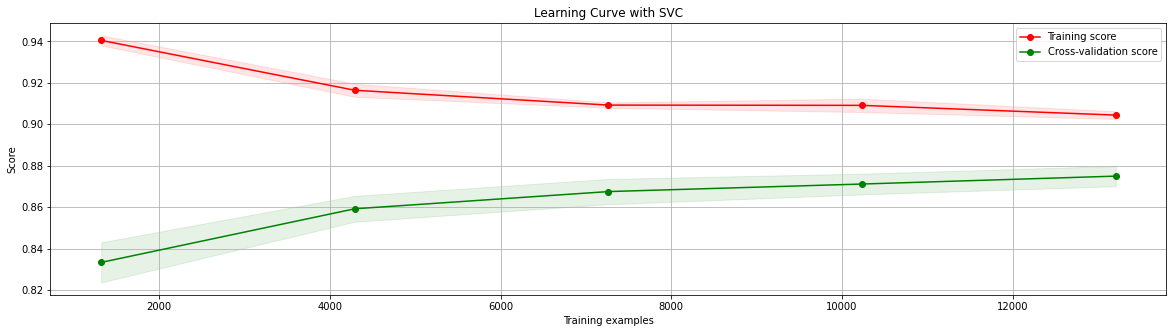

In [49]:
plot_learning_curve(svc_estimator, "SVC", housing_prepared, housing_labels)

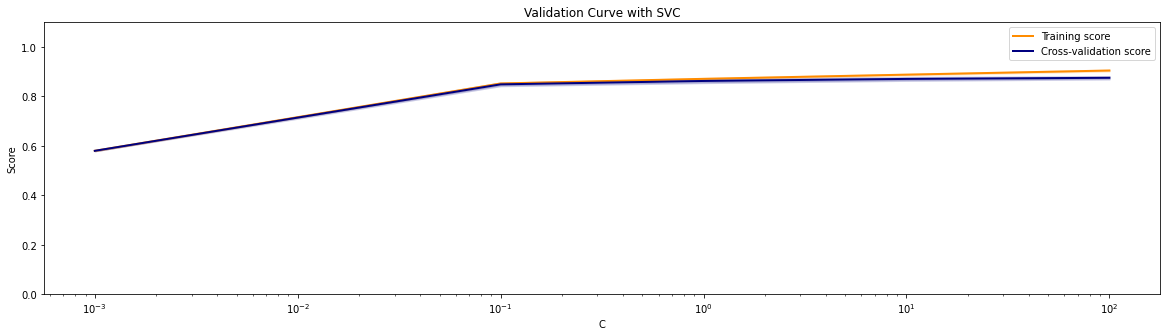

In [50]:
plot_validation_curve(svc_estimator, "SVC", housing_prepared, housing_labels, param_name="C", param_range=[0.001, 0.1, 1, 10, 100])

# 2) KNN

In [51]:
from sklearn.neighbors import KNeighborsClassifier
k_range = np.arange(1,30)
param_knn = dict(n_neighbors = k_range)
knn_estimator, knn_score = best_estimator(KNeighborsClassifier(), param_knn, housing_prepared, housing_labels, 5)

Best Params: {'n_neighbors': 21}
Best Score: 0.8521077419294503
Best Estimator: KNeighborsClassifier(n_neighbors=21)


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

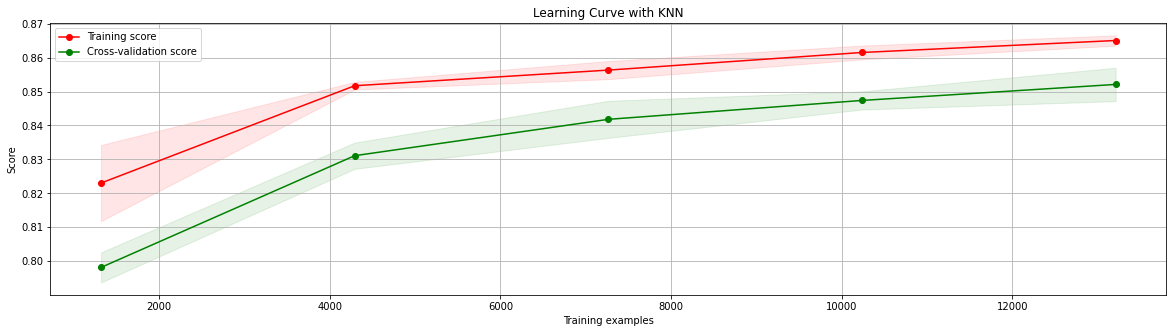

In [52]:
plot_learning_curve(knn_estimator, "KNN", housing_prepared, housing_labels)

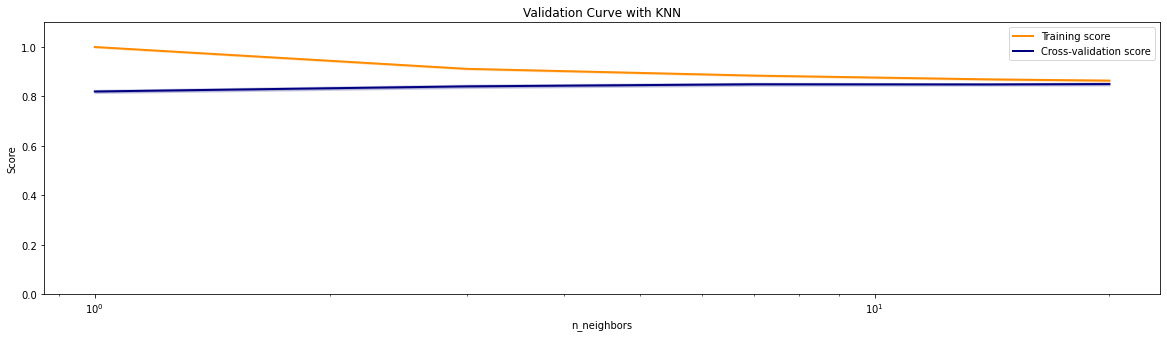

In [53]:
param_range = [1,3,7,14,20]
plot_validation_curve(knn_estimator, "KNN", housing_prepared, housing_labels, param_name="n_neighbors", param_range = param_range)

# 3) Logistic Regression

In [54]:
from sklearn.linear_model import LogisticRegression
log_params = {
    'C': np.logspace(-3,3,7),
    'penalty':['l1','l2']# l1 lasso l2 ridge
}
log_estimator,log_score = best_estimator(LogisticRegression(max_iter=1000), log_params,housing_prepared, housing_labels,5)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:921: UserWarning: One or more of the test scores are non-finite: [       nan 0.80601987        nan 0.83751209        nan 0.84568838
        nan 0.84817127        nan 0.84847398        nan 0.848474
        nan 0.848474  ]
  category=UserWarning


Best Params: {'C': 100.0, 'penalty': 'l2'}
Best Score: 0.8484740025815783
Best Estimator: LogisticRegression(C=100.0, max_iter=1000)


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

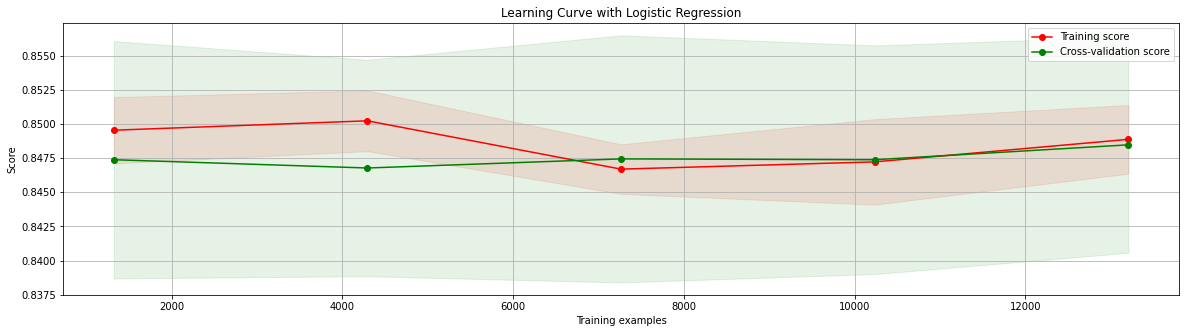

In [55]:
plot_learning_curve(log_estimator, "Logistic Regression", housing_prepared, housing_labels)

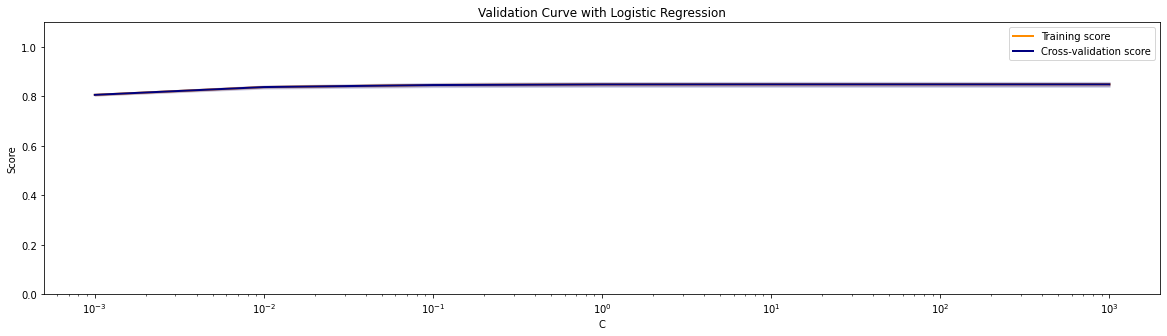

In [56]:
param_range = np.logspace(-3,3,7)
plot_validation_curve(log_estimator, "Logistic Regression", housing_prepared, housing_labels, param_name="C", param_range = param_range)

# 4) Decision Tree

In [57]:
from sklearn.tree import DecisionTreeClassifier
dtree_params = {
     'max_depth':np.arange(1,20)
}
dt_estimator,dt_score = best_estimator(DecisionTreeClassifier(), dtree_params, housing_prepared, housing_labels, 5)

Best Params: {'max_depth': 10}
Best Score: 0.8484739842439
Best Estimator: DecisionTreeClassifier(max_depth=10)


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

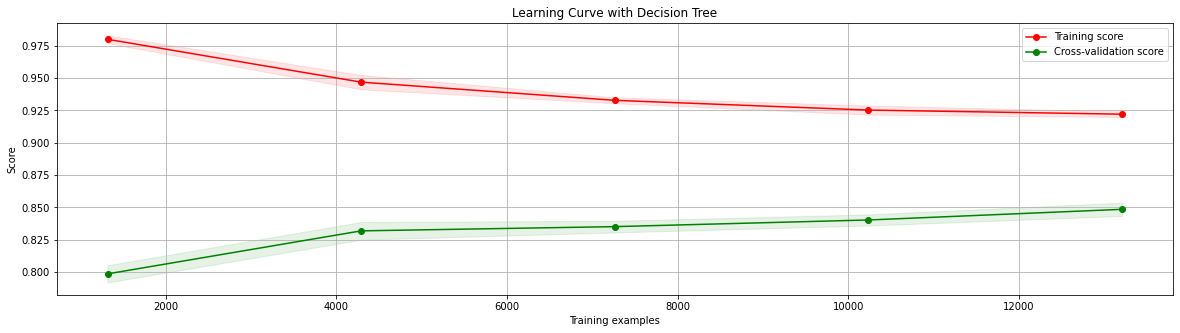

In [58]:
plot_learning_curve(dt_estimator, "Decision Tree", housing_prepared, housing_labels)

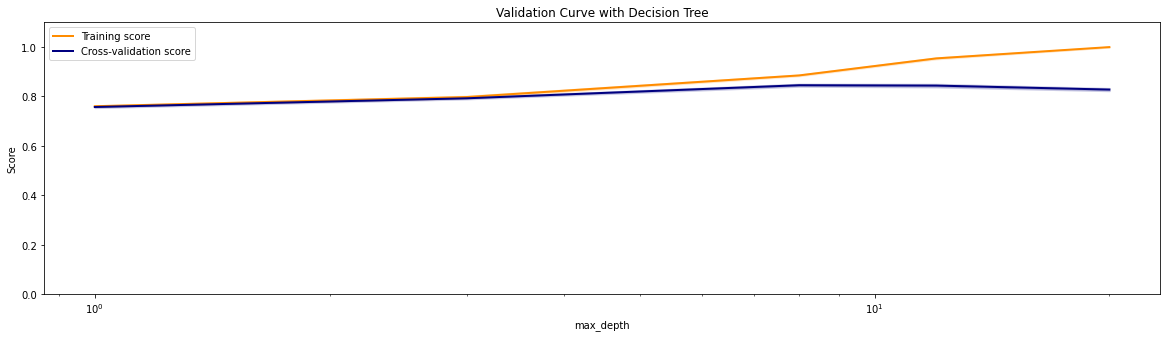

In [59]:
param_range = [1,3,8,12,20]
plot_validation_curve(dt_estimator, "Decision Tree", housing_prepared, housing_labels, param_name="max_depth", param_range = param_range)

# 5) MLP

`https://scikit-learn.org/stable/modules/neural_networks_supervised.html`

In [60]:
from sklearn.neural_network import MLPClassifier
mlp_params = {
    'hidden_layer_sizes': [(5,),(10,),(20,)]
}
mlp_estimator, mlp_score = best_estimator(MLPClassifier(max_iter=1000), mlp_params, housing_prepared, housing_labels, 5)

Best Params: {'hidden_layer_sizes': (20,)}
Best Score: 0.8659160688125052
Best Estimator: MLPClassifier(hidden_layer_sizes=(20,), max_iter=1000)


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

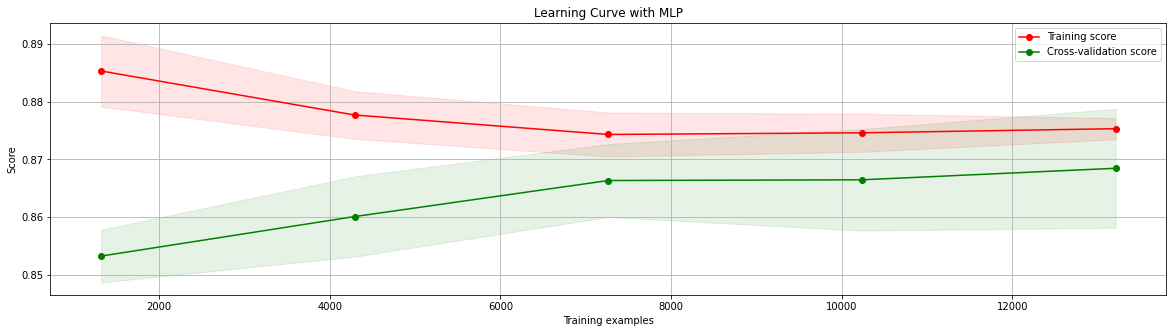

In [61]:
plot_learning_curve(mlp_estimator, "MLP", housing_prepared, housing_labels)

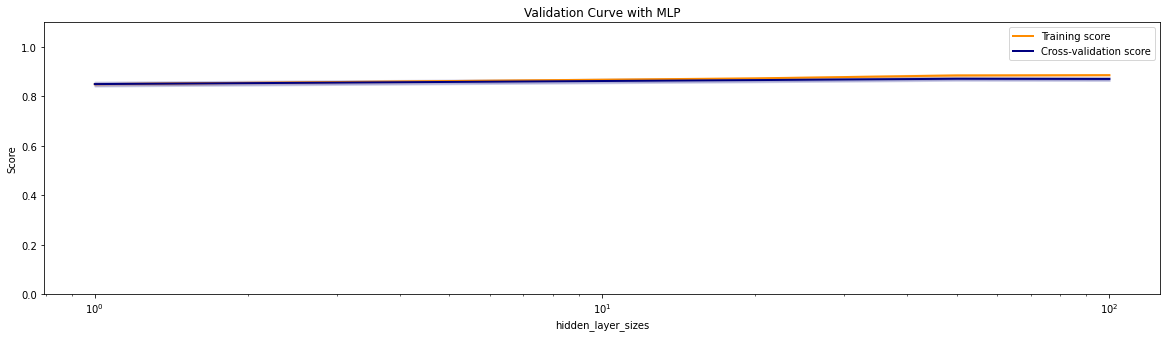

In [62]:
param_range = [1, 20, 50,100]
plot_validation_curve(mlp_estimator, "MLP", housing_prepared, housing_labels, param_name="hidden_layer_sizes", param_range = param_range)

# 6) Ensemble - Random Forest

In [63]:
from sklearn.ensemble import RandomForestClassifier
rForest = [
        {'n_estimators': [3, 10, 30, 50], 'max_features': [2, 4, 6, 8]},
        {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]
rf_estimator, rf_score = best_estimator(RandomForestClassifier(), rForest, housing_prepared, housing_labels, 5)

Best Params: {'max_features': 4, 'n_estimators': 100}
Best Score: 0.8877181198084886
Best Estimator: RandomForestClassifier(max_features=4)


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

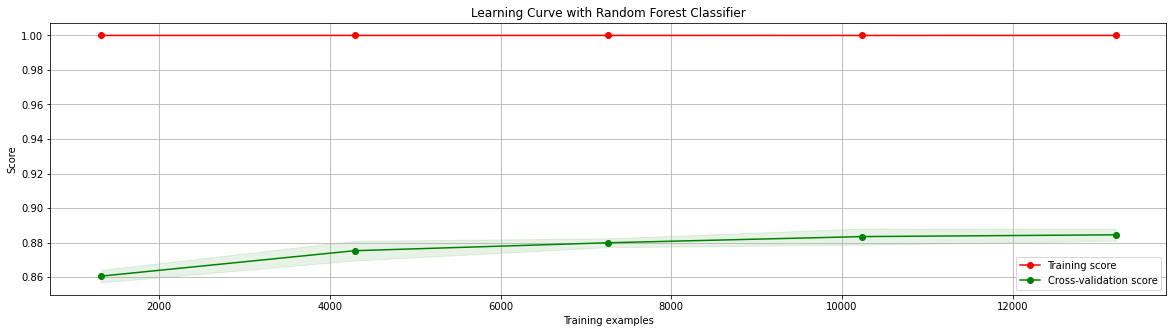

In [64]:
plot_learning_curve(rf_estimator, "Random Forest Classifier", housing_prepared, housing_labels)

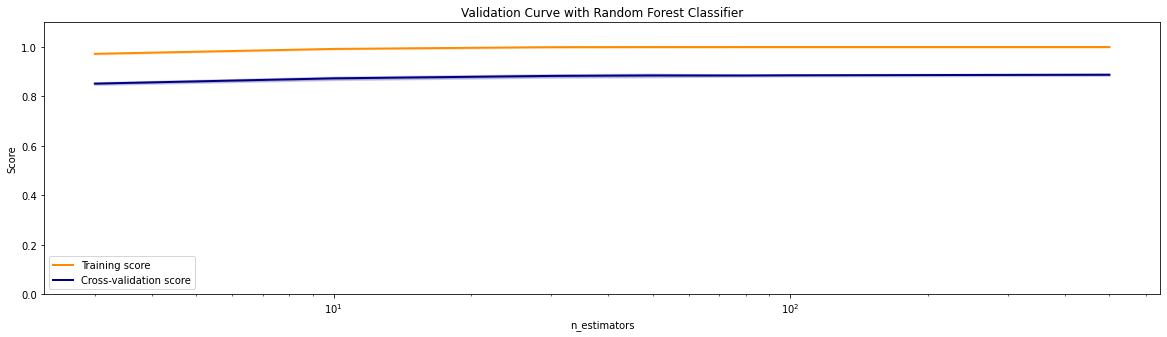

In [65]:
param_range = [3, 10, 30, 50, 80, 100, 500]
plot_validation_curve(rf_estimator, "Random Forest Classifier", housing_prepared, housing_labels, param_name="n_estimators", param_range = param_range)

# 7) Voting Classifier

In [66]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

eclf = VotingClassifier(voting='hard', 
                        estimators=[('svc', svc_estimator), ('knn', knn_estimator), ('log', log_estimator), ('dt', dt_estimator), ('mlp', mlp_estimator), ('rf', rf_estimator)] )
eclf = eclf.fit(housing_prepared, housing_labels)
y_pred_voting = eclf.predict(X_test_prepared)
voting_score = accuracy_score(y_test, y_pred_voting)
print(f"Voting Accuracy Score = {voting_score}")

Voting Accuracy Score = 0.8691860465116279


# 8) AutoML

In [67]:
#Auto-sklearn 2.0 includes latest research on automatically configuring the AutoML system itself and contains a multitude of improvements which speed up the fitting the AutoML system.
# from autosklearn.experimental.askl2 import AutoSklearn2Classifier
# import autosklearn.classification
# import sklearn.model_selection
# import sklearn.datasets
# import sklearn.metrics

autoMl = autosklearn.classification.AutoSklearnClassifier()
autoMl.fit(housing_prepared, housing_labels)

y_pred_automl = autoMl.predict(X_test_prepared)
autoMl_score =  sklearn.metrics.accuracy_score(y_test, y_pred_automl)
print(f"AutoML Accuracy Score = {autoMl_score}")


AutoML Accuracy Score = 0.8783914728682171


# AUC Curve

`https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html`

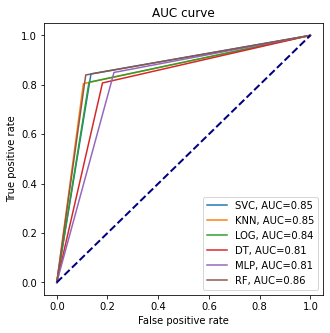

In [68]:
from sklearn.metrics import roc_curve
from sklearn import metrics
def plot_roc_curve(estimators, titles, X, y, ax=None):
    if ax is None: _, ax = plt.subplots(figsize=(5, 5))

    for i, estimator in enumerate(estimators):
      y_pred = estimator.predict(X)
      fpr, tpr, _ = roc_curve(y, y_pred)
      ax.plot(fpr, tpr, label=f"{titles[i]}, AUC=" + "{:.2f}".format(metrics.auc(fpr, tpr)))

    ax.set_title('AUC curve')
    ax.legend(loc='best')
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate') 
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    return plt

estimators = [svc_estimator, knn_estimator, log_estimator, dt_estimator, mlp_estimator, rf_estimator]
titles = ['SVC','KNN','LOG','DT','MLP', 'RF']
plot_roc_curve(estimators, titles, X_test_prepared, y_test)
plt.show()


# SHAP

`https://www.explorium.ai/blog/interpretability-and-explainability-part-2/`

In [69]:
import shap

row = 4
data_for_prediction = X_test_prepared.iloc[row]  # use 1 arbitrary row of data
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

explainer = shap.TreeExplainer(dt_estimator)
shap_values = explainer.shap_values(data_for_prediction)
# The shap_values is a list with two arrays. It’s cumbersome to review raw arrays, but the shap package has a nice way to visualize the results.

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

In [70]:
y_test

5241     1
10970    1
20351    1
6568     0
13285    0
        ..
20519    0
17430    0
4019     1
12107    0
2398     0
Name: expensive, Length: 4128, dtype: int64